In [2]:
import cv2 # pip install opencv-python-headless or conda install opencv 
from matplotlib import pyplot as plt

In [4]:
bgr_image = cv2.imread("/kaggle/input/bildebehandling/topaz.jpg") # cv2 read in BGR format.

In [6]:
# Due to jupyters architecture we can not use cv2.imshow() so we create a helper method to utilize pyplot.
def show_image(image, title):
    plt.imshow(image)
    plt.title(title)
    plt.show()

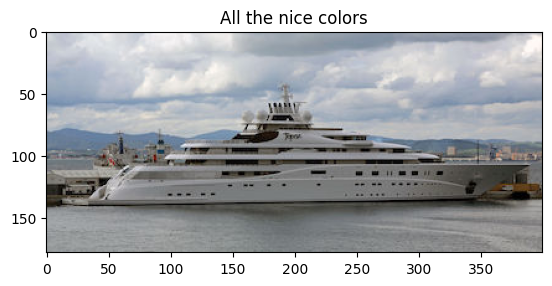

In [7]:
# Show the RGB image.
show_image(cv2.cvtColor(bgr_image, cv2.COLOR_BGR2RGB), "All the nice colors")

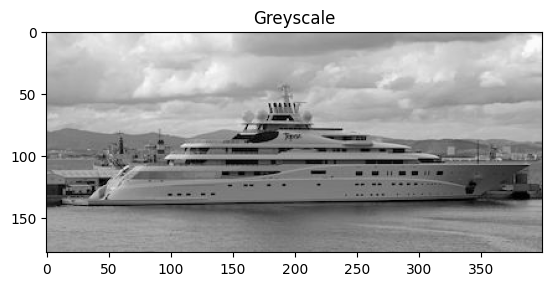

In [8]:


# Convert to grayscale for more efficient work.
# Do operations on grayscale are more efficient since there is less colors.
gray_image = cv2.cvtColor(bgr_image, cv2.COLOR_BGR2GRAY) # First: Make it grayscale.
show_image(cv2.cvtColor(gray_image, cv2.COLOR_BGR2RGB), "Greyscale") # Third: View the result.



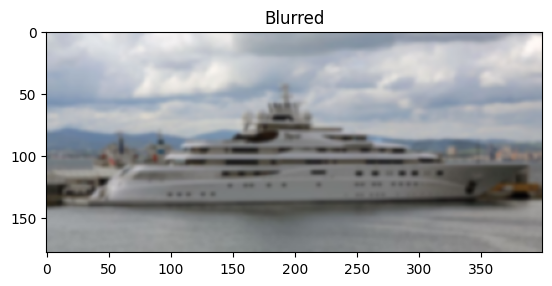

In [9]:


# Blur the image with Gaussian blur, a popular and relatively fast blur algorithm.
# We use a window of size 7px * 7px, which means that we average values in the window for blur effect.
# Larger window will result in more blur, but will be slower.
blurred_image = cv2.GaussianBlur(bgr_image, (7,7), 0)
show_image(cv2.cvtColor(blurred_image, cv2.COLOR_BGR2RGB), "Blurred")



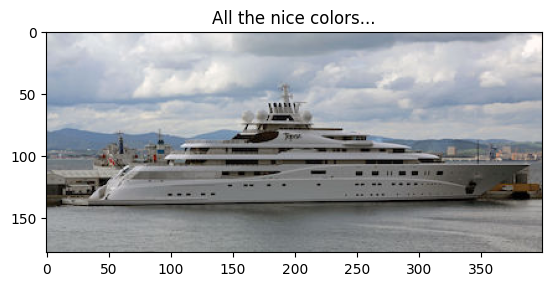

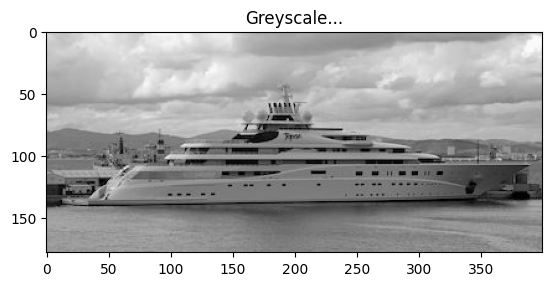

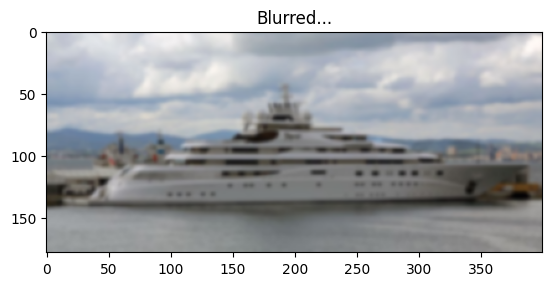

In [10]:
# All together now.
show_image(cv2.cvtColor(bgr_image, cv2.COLOR_BGR2RGB), "All the nice colors...")
show_image(cv2.cvtColor(gray_image, cv2.COLOR_BGR2RGB), "Greyscale...")
show_image(cv2.cvtColor(blurred_image, cv2.COLOR_BGR2RGB), "Blurred...")


## Edge detection med OpenCV

Nyttig når vi skal finne objekter i et bilde. Algoritmen ser etter endringer i farge, lysstyrke med mer for å finne kanter.

http://en.wikipedia.org/wiki/Edge_detection

http://en.wikipedia.org/wiki/Canny_edge_detector


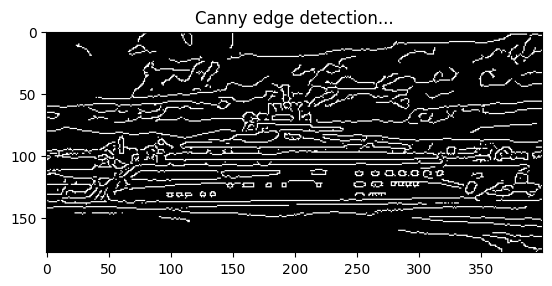

In [11]:
# https://docs.opencv.org/4.6.0/dd/d1a/group__imgproc__feature.html#ga04723e007ed888ddf11d9ba04e2232de
canny = cv2.Canny(blurred_image, 10, 50) # cv2.Canny(image, lower treshold, upper treshold)
show_image(cv2.cvtColor(canny, cv2.COLOR_BGR2RGB), "Canny edge detection...")

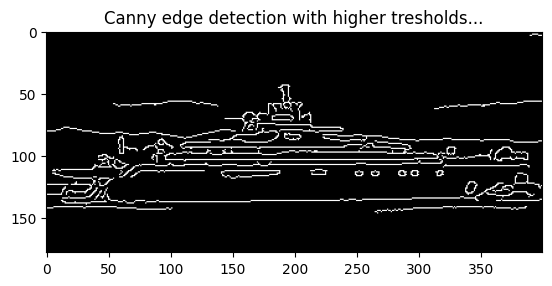

In [12]:
canny = cv2.Canny(blurred_image, 50, 150) # cv2.Canny(image, lower treshold, upper treshold)
show_image(cv2.cvtColor(canny, cv2.COLOR_BGR2RGB), "Canny edge detection with higher tresholds...")


## Finne objekter med OpenCV

Nå som vi har greid å detektere kanter på objekter kan vi utvide koden vår til å telle objekter i bildet.


In [15]:
# Prepare a new image for processing.
bgr_image_contours = cv2.imread("/kaggle/input/bildebehandling/cards.jpg") # cv2 read in BGR format.
gray_image_contours = cv2.cvtColor(bgr_image_contours, cv2.COLOR_BGR2GRAY) # Grayscale for efficient processing
blurred_image_contours = cv2.GaussianBlur(gray_image_contours, (7,7), 0) # Blur it for efficient processing
canny_contours = cv2.Canny(blurred_image_contours, 30, 100) # Detect the edges

In [16]:
# Contours are just a fancy name for edges.
# RETR_EXTERNAL = Find only the outmost contours, not contours inside contours.
# CHAIN_APPROX_SIMPLE = Use simple approximation.
# https://docs.opencv.org/4.6.0/d3/dc0/group__imgproc__shape.html#gadf1ad6a0b82947fa1fe3c3d497f260e0
contours, hierarchy = cv2.findContours(canny_contours, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

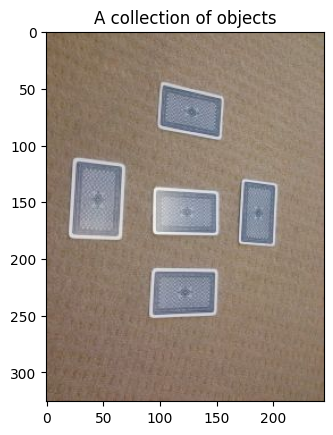

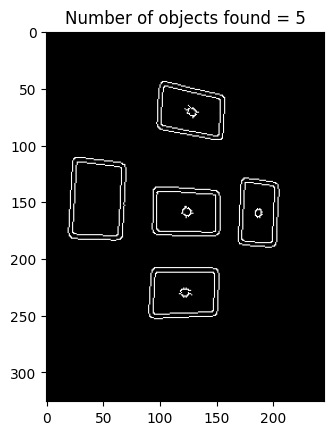

In [17]:


show_image(cv2.cvtColor(bgr_image_contours, cv2.COLOR_BGR2RGB), "A collection of objects")
show_image(cv2.cvtColor(canny_contours, cv2.COLOR_BGR2RGB), "Number of objects found = %s" % len(contours))



In [18]:
# bgr_image_contours = The image we want to draw on..
# contours = The contours we found in the last findContours(...) function. 
# -1 = We want all contours to be drawn (we can choose to only draw certain contours). 
# (0,255,0) = Color of the contour we are drawing.
# 2 = Thickness.
# https://docs.opencv.org/3.4/d6/d6e/group__imgproc__draw.html#ga746c0625f1781f1ffc9056259103edbc
traced_contours = cv2.drawContours(bgr_image_contours, contours, -1, (0,255,0), 2)

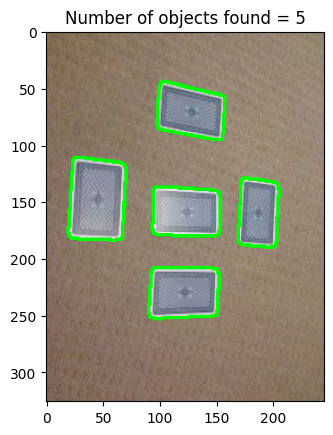

In [19]:
show_image(cv2.cvtColor(traced_contours, cv2.COLOR_BGR2RGB), "Number of objects found = %s" % len(contours))


## Ansiktsgjenkjenkjenning med OpenCV

Haar Cascade er en ML objektgjenkjennings algoritme som er basert på en artikkel som ble publisert i "International Journal of Computer Vision" i 2001. Artikkelen var igjen basert på forskningsoppgaven deres "Rapid Object Detection using a Boosted Cascade of Simple Features".

Konseptet baserer seg på at man kan trene opp / finne mønstre som kan gjenbrukes senere. Man har et (eller mange bilder) av ansikt hvor bildene scannes etter mønstre som går igjen i alle bildene som er ansikt. Et mønster kan være hvordan forskjellige piksler står i forhold til hverandre, pikslenes skarphet og lysintensitet med mer. Disse kjennetegnene lagres som såkalte features, og for et ansikt kan vi ha rundt 6000 slike features. Ved hjelp av disse featurene kan vi da teste andre bilder, og om vi får treff på nok features så har vi funnet objektet vi leter etter.

Original paper: https://www.cs.cmu.edu/~efros/courses/LBMV07/Papers/viola-cvpr-01.pdf

Flere datasett: https://github.com/opencv/opencv/tree/master/data/haarcascades


In [21]:
# Create the haar cascade
cascPath = "/kaggle/input/bildebehandling/haarcascade_frontalface_default.xml" # Just an xml file that contains data about a face.
faceCascade = cv2.CascadeClassifier(cascPath) # Load the cascade into memory.

In [24]:
face_image = cv2.imread("/kaggle/input/bildebehandling/abba.png") # cv2 read in BGR format.
gray_image_face = cv2.cvtColor(face_image, cv2.COLOR_BGR2GRAY)

libpng warning: iCCP: profile 'Photoshop ICC profile': 'GRAY': Gray color space not permitted on RGB PNG


In [26]:
# The detectMultiScale function is a general function that detects objects.
# Since we are calling it on the face cascade, thats what it detects. 
# gray_image_face = Our image, in grayscale.
# scaleFactor = Compensate for faces being near / far from the camera effect. 
# minNeighbors = How many objects are detected near the current moving window before it declares the face found. 
# minSize = The size of each window.
faces = faceCascade.detectMultiScale(
    gray_image_face,
    scaleFactor=1.1,
    minNeighbors=5,
    minSize=(30, 30),
    flags = cv2.CASCADE_SCALE_IMAGE
)

# Kjører algoritmen på bildet vårt

In [27]:
# Iterate the list of faces and draw a rectangle around the faces.
for (x, y, w, h) in faces:
    cv2.rectangle(face_image, (x, y), (x+w, y+h), (0, 255, 0), 2)

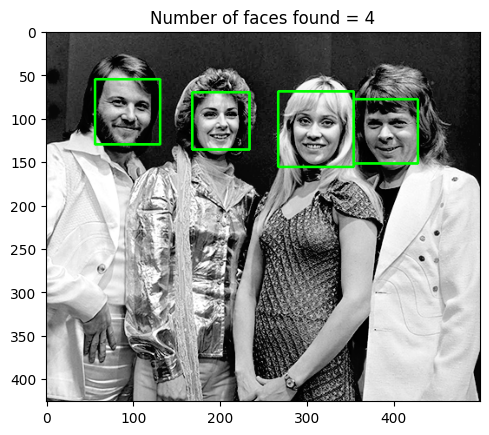

In [28]:
show_image(cv2.cvtColor(face_image, cv2.COLOR_BGR2RGB), "Number of faces found = %s" % len(faces))

In [31]:
face_image_b = cv2.imread("/kaggle/input/bildebehandling/celebrities.png") # cv2 read in BGR format.
gray_image_face_b = cv2.cvtColor(face_image_b, cv2.COLOR_BGR2GRAY)

In [34]:
faces = faceCascade.detectMultiScale(
    gray_image_face_b,
    scaleFactor=1.1,
    minNeighbors=1,
    minSize=(30, 30),
    flags = cv2.CASCADE_SCALE_IMAGE
)

In [35]:
# Draw a rectangle around the faces
print(faces)
for (x, y, w, h) in faces:
    cv2.rectangle(face_image_b, (x, y), (x+w, y+h), (0, 255, 0), 1)

[[202  21  33  33]
 [ 52   7  36  36]
 [112  24  35  35]
 [159  10  33  33]]


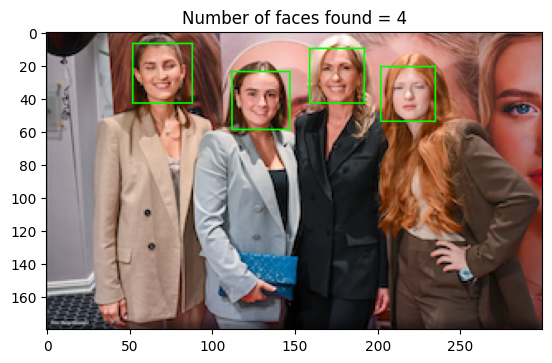

In [36]:
show_image(cv2.cvtColor(face_image_b, cv2.COLOR_BGR2RGB), "Number of faces found = %s" % len(faces))

Vi har nå jobbet med stillbilder, men det skal ikke mange ekstra linjer med kode til for å analysere videoer (som er en samling av stillbilder) på samme måten. Som nevnt er sanntidsbehandling hovedfokuset til OpenCV.

## Oppgave

0: Opprett et nytt kodeprosjekt / fil.

1: Finn et egnet bilde og se om du greier å detektere andre features, f.eks munn / øyner.

NB! Dere finner flere trente haarcascade set her https://github.com/opencv/opencv/tree/master/data/haarcascades


In [51]:
# kode24 = cv2.imread("/kaggle/input/opencv-oppgave/kode24_funktive.jpg") # cv2 read in BGR format.
kode24 = cv2.imread("/kaggle/input/fjas-og-tull/kode24_meta_og_google.jpg") # cv2 read in BGR format.


In [52]:
gray_kode24 = cv2.cvtColor(kode24, cv2.COLOR_BGR2GRAY)

In [53]:
kod24_faces = faceCascade.detectMultiScale(
    gray_kode24,
    scaleFactor=1.1,
    minNeighbors=1,
    minSize=(30, 30),
    flags = cv2.CASCADE_SCALE_IMAGE
)

In [54]:
# Draw a rectangle around the faces
print(kod24_faces)
for (x, y, w, h) in kod24_faces:
    cv2.rectangle(kode24, (x, y), (x+w, y+h), (0, 255, 0), 1)

[[302 112 253 253]
 [234 154 110 110]
 [645 173 249 249]
 [355 379 176 176]]


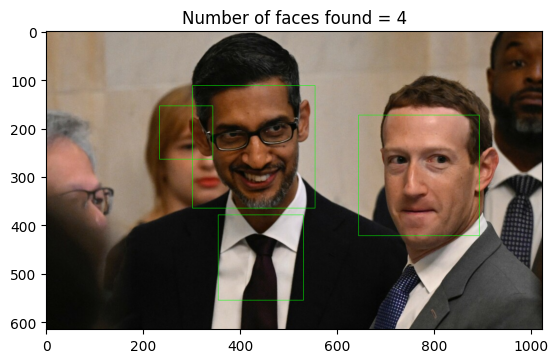

In [55]:
show_image(cv2.cvtColor(kode24, cv2.COLOR_BGR2RGB), "Number of faces found = %s" % len(kod24_faces))